### **Dependencies**

In [54]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

## **Load Data**

In [55]:
df = pd.read_csv("../../src/merged_orgas.csv")

In [56]:
df.columns

Index(['iati_id', 'iati_orga_id', 'orga_abbreviation', 'orga_full_name',
       'title_en', 'title_other', 'title_main', 'country_code_list', 'country',
       'country_name', 'country_flag', 'description_en', 'description_other',
       'description_main', 'status', 'crs_5_code', 'crs_5_name', 'crs_3_code',
       'crs_3_name', 'title_and_description', 'sgd_pred_code', 'sgd_pred_str',
       'client'],
      dtype='object')

In [57]:
df['crs_3_list'] = df['crs_3_code'].apply(
    lambda x: [element.strip() for element in x.split(';') if element.strip()] if pd.notna(x) else []
)
df['crs_3_list'].head()

0    [140]
1    [331]
2    [331]
3    [240]
4    [430]
Name: crs_3_list, dtype: object

In [58]:
df['crs_5_list'] = df['crs_5_code'].apply(
    lambda x: [element.strip() for element in x.split(';') if element.strip()] if pd.notna(x) else []
)
df['crs_5_list'].head()

0    [14010]
1    [33130]
2    [33130]
3    [24030]
4    [43010]
Name: crs_5_list, dtype: object

## **Load Models**

In [59]:
def calculate_bert_similarity(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**encoded_input)
    
    embeddings = normalize(outputs.last_hidden_state.mean(dim=1), norm='l2')
    similarity = cosine_similarity(embeddings[0:1], embeddings[1:2]).item()

    return similarity


In [60]:
def calculate_tfidf_similarity(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    vectorizer = TfidfVectorizer()

    tfidf_matrix = normalize(vectorizer.fit_transform(sentences), norm='l2')
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2]).item()

    return similarity


In [61]:
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')

In [62]:
def mini_lm(iati_ids):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    embeddings = normalize(minilm_model.encode(sentences), norm='l2')
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]]).item()

    return similarity


In [63]:
def mini_lm_weighted(iati_ids, ws, wc3, wc5):
    filtered_df = df[df['iati_id'].isin(iati_ids)]
    sentences = filtered_df["title_and_description"].tolist()

    embeddings = normalize(minilm_model.encode(sentences), norm='l2')
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]]).item()

    def is_match(set1, set2):
        return not set1.isdisjoint(set2)

    crs3_codes = filtered_df["crs_3_list"].tolist()
    if is_match(set(crs3_codes[0]), set(crs3_codes[1])):
        similarity += ws

    crs5_codes = filtered_df["crs_5_list"].tolist()
    if is_match(set(crs5_codes[0]), set(crs5_codes[1])):
        similarity += wc3

    sdg_codes = filtered_df["sgd_pred_code"].tolist()
    if sdg_codes[0] == sdg_codes[1]:
        similarity += wc5

    return similarity / (1+ ws + wc3 + wc5)

## **Evaluate Ground Truth Project matches**

### **Project Matches**

In [64]:
true_matches = [
    ["DE-1-201521939", "XM-DAC-46004-35183-013-LN2285"],
    ["DE-1-201923200", "44000-P177959"],
    ["DE-1-201722149", "44000-P127079"],
    ["DE-1-202221729", "44000-P170419"],
    ["DE-1-201822519", "44000-P176932"],
    ["DE-1-202120236", "44000-P151357"],
    ["DE-1-201822535", "44000-P172422"],
    ["DE-1-201822535", "44000-P169669"],
    ["DE-1-202322022", "44000-P124761"],
    ["DE-1-201923200", "44000-P166360"],
    ["DE-1-202120053", "44000-P085752"],
        ]

no_matches = [
    ["DE-1-201729375-0", "XM-DAC-5-7-6619182"],
    ["DE-1-201775048-0", "XI-IATI-IADB-CH-L1142"],
    ["XI-IATI-IADB-CH-L1142", "XM-DAC-46004-46059-002-LN3205"],
    ["DE-1-200967406", "46002-P-MW-KA0-002"],
    ["DE-1-200166744", "XM-DAC-918-3-20160661-88672"],
    ["DE-1-201901180-0", "44000-P112780"],
    ["DE-1-202070399", "44000-P112780"],
    ["DE-1-201606003-1475", "XM-DAC-918-3-20220488-94840"],
    ["DE-1-201336619", "44000-P167651"],
    ["DE-1-201568633", "44000-P159476"],
]

matches = true_matches + no_matches

results_bert = []
results_tfidf = []
results_minilm = []

In [65]:
for i in matches:
    results_bert.append(
        calculate_bert_similarity(i)
    )
    results_tfidf.append(
        calculate_tfidf_similarity(i)
    )
    results_minilm.append(
        mini_lm(i)
    )

results_all = [results_bert, results_tfidf, results_minilm]

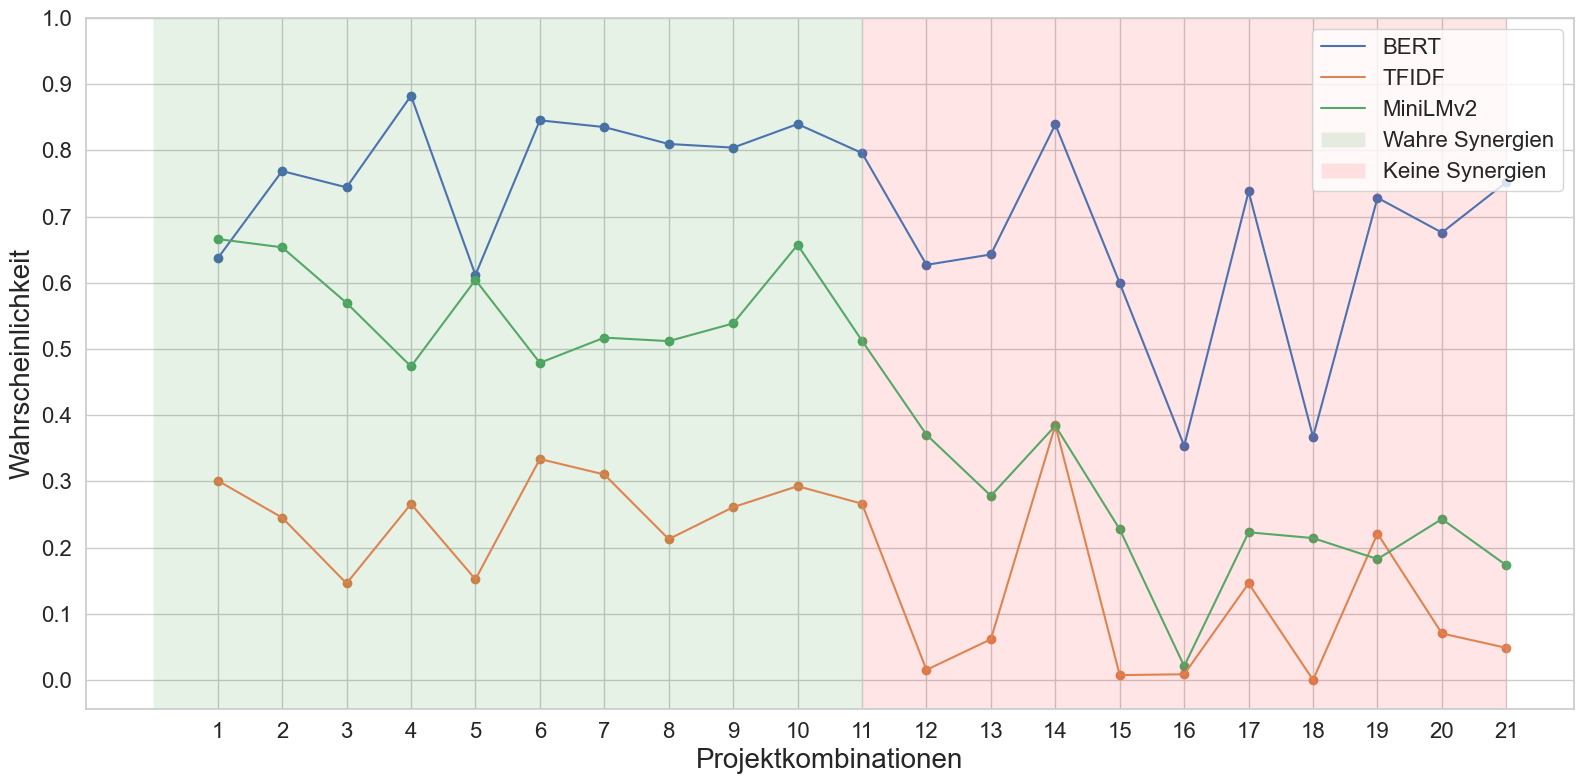

In [66]:
sns.set(style='whitegrid')

labels = ["BERT", "TFIDF", "MiniLMv2"]
linestyles = ["-", "-", "-"]

plt.figure(figsize=(16, 8))
x_values = range(1, len(results_all[0])+1)

for i, results in enumerate(results_all):
    plt.plot(x_values, results, label=labels[i], linestyle=linestyles[i], alpha=1)
    plt.scatter(x_values, results)

#plt.title('Verschiedene Modelle zur Berechnung der Projektähnlichkeit')
plt.axvspan(0, len(true_matches), facecolor='green', alpha=0.1, label='Wahre Synergien')
plt.axvspan(len(true_matches), len(matches), facecolor='red', alpha=0.1, label='Keine Synergien')
plt.xlabel('Projektkombinationen', fontsize=20)
plt.ylabel('Wahrscheinlichkeit', fontsize=20)
plt.xticks(x_values, fontsize=16) 
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16) 
plt.legend()
plt.tight_layout()
plt.legend(fontsize=16)

plt.savefig('../exploreation/img/eval_gt.png')
plt.show()


In [67]:
from sklearn.preprocessing import MinMaxScaler

tfidf_array = np.array(results_tfidf).reshape(-1, 1)
minilm_array = np.array(results_minilm).reshape(-1, 1)
bert_array = np.array(results_bert).reshape(-1, 1)

# Initialisieren des Min-Max-Scalers
scaler = MinMaxScaler()

# Skalieren der Daten
tfidf_scaled = scaler.fit_transform(tfidf_array)
minilm_scaled = scaler.fit_transform(minilm_array)
bert_scaled = scaler.fit_transform(bert_array)

results_all = [bert_scaled, tfidf_scaled, minilm_scaled]

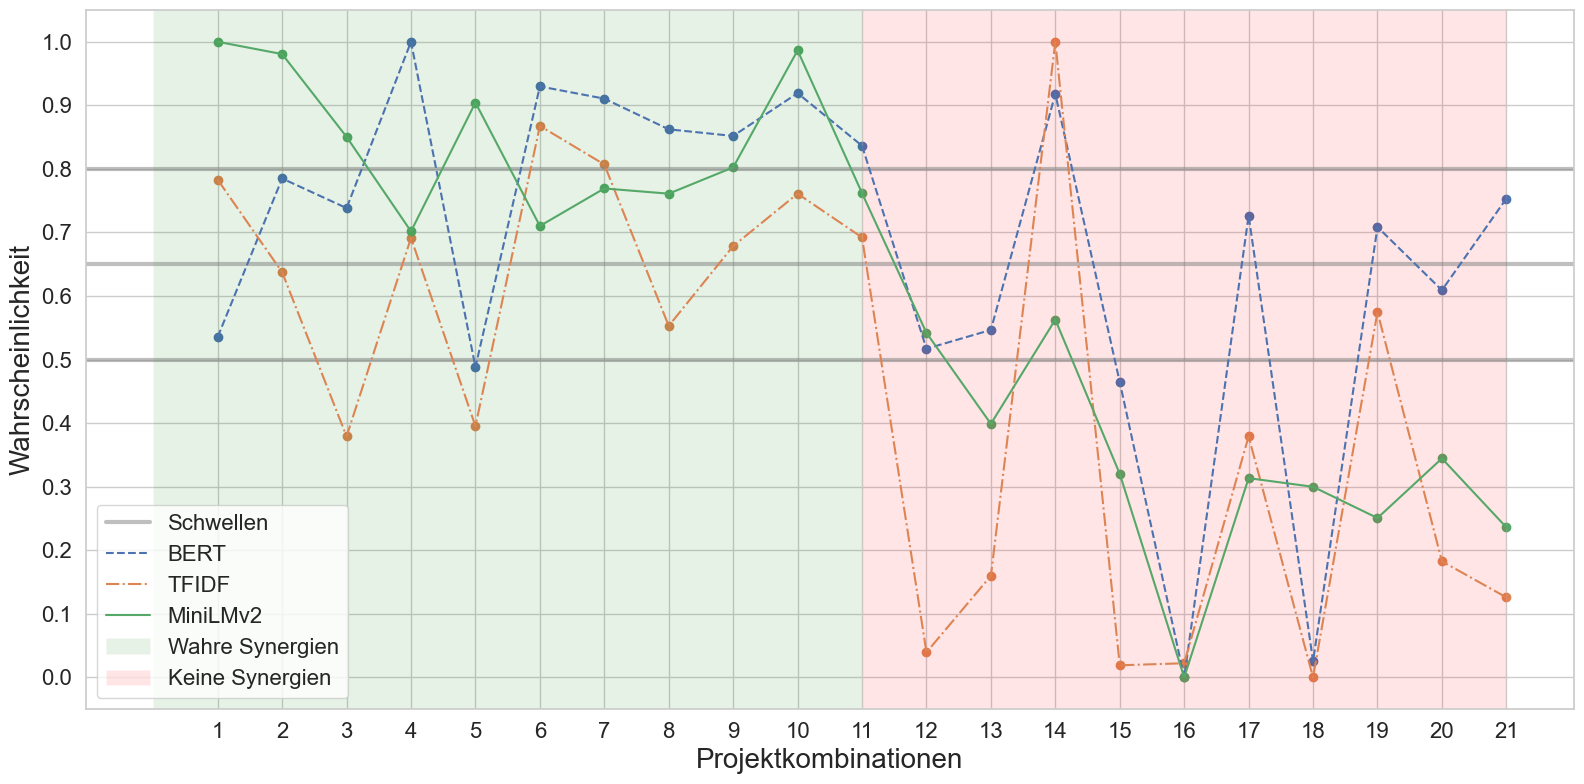

In [68]:
sns.set(style='whitegrid')

labels = ["BERT", "TFIDF", "MiniLMv2"]
linestyles = ["--", "-.", "-"]

plt.figure(figsize=(16, 8))
x_values = range(1, len(results_all[0])+1)

plt.axhline(y=0.8, color='gray', linestyle='-', linewidth=3, alpha=.5, label="Schwellen")
plt.axhline(y=0.65, color='gray', linestyle='-', linewidth=3, alpha=.5)
plt.axhline(y=0.5, color='gray', linestyle='-', linewidth=3, alpha=.5)

for i, results in enumerate(results_all):
    plt.plot(x_values, results, label=labels[i], linestyle=linestyles[i], alpha=1)
    plt.scatter(x_values, results)

#plt.title('Verschiedene Modelle zur Berechnung der Projektähnlichkeit')
plt.axvspan(0, len(true_matches), facecolor='green', alpha=0.1, label='Wahre Synergien')
plt.axvspan(len(true_matches), len(matches), facecolor='red', alpha=0.1, label='Keine Synergien')
plt.xlabel('Projektkombinationen', fontsize=20)
plt.ylabel('Wahrscheinlichkeit', fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16) 
plt.xticks(x_values, fontsize=16) 
plt.legend()
plt.tight_layout()
plt.legend(fontsize=16)

plt.savefig('../exploreation/img/eval_gt_norm.png')
plt.show()


## **Evaluate with metrics**

In [69]:
threshold = 0.5

ground_truth_labels = [1 for i in range(len(true_matches))] + [0 for i in range(len(no_matches))]

tfidf_predictions = (tfidf_scaled >= threshold).astype(int)
minilm_predictions = (minilm_scaled >= threshold).astype(int)
bert_predictions = (bert_scaled >= threshold).astype(int)

# Calculate precision, recall, and F1-score
accuracy_tfidf = accuracy_score(ground_truth_labels, tfidf_predictions)
accuracy_minilm = accuracy_score(ground_truth_labels, minilm_predictions)
accuracy_bert = accuracy_score(ground_truth_labels, bert_predictions)

precision_tfidf = precision_score(ground_truth_labels, tfidf_predictions)
recall_tfidf = recall_score(ground_truth_labels, tfidf_predictions)
f1_tfidf = f1_score(ground_truth_labels, tfidf_predictions)

precision_minilm = precision_score(ground_truth_labels, minilm_predictions)
recall_minilm = recall_score(ground_truth_labels, minilm_predictions)
f1_minilm = f1_score(ground_truth_labels, minilm_predictions)

precision_bert = precision_score(ground_truth_labels, bert_predictions)
recall_bert = recall_score(ground_truth_labels, bert_predictions)
f1_bert = f1_score(ground_truth_labels, bert_predictions)

# Print the results
print(f"Threshold: {threshold}")

print("TF-IDF:")
print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1-score:", f1_tfidf)

print("\nMiniLM:")
print("Accuracy:", accuracy_minilm)
print("Precision:", precision_minilm)
print("Recall:", recall_minilm)
print("F1-score:", f1_minilm)

print("\nBERT:")
print("Accuracy:", accuracy_bert)
print("Precision:", precision_bert)
print("Recall:", recall_bert)
print("F1-score:", f1_bert)

Threshold: 0.5
TF-IDF:
Accuracy: 0.8095238095238095
Precision: 0.8181818181818182
Recall: 0.8181818181818182
F1-score: 0.8181818181818182

MiniLM:
Accuracy: 0.9047619047619048
Precision: 0.8461538461538461
Recall: 1.0
F1-score: 0.9166666666666666

BERT:
Accuracy: 0.6190476190476191
Precision: 0.5882352941176471
Recall: 0.9090909090909091
F1-score: 0.7142857142857143


In [70]:
threshold = 0.65

ground_truth_labels = [1 for i in range(len(true_matches))] + [0 for i in range(len(no_matches))]

tfidf_predictions = (tfidf_scaled >= threshold).astype(int)
minilm_predictions = (minilm_scaled >= threshold).astype(int)
bert_predictions = (bert_scaled >= threshold).astype(int)

# Calculate precision, recall, and F1-score
accuracy_tfidf = accuracy_score(ground_truth_labels, tfidf_predictions)
accuracy_minilm = accuracy_score(ground_truth_labels, minilm_predictions)
accuracy_bert = accuracy_score(ground_truth_labels, bert_predictions)

precision_tfidf = precision_score(ground_truth_labels, tfidf_predictions)
recall_tfidf = recall_score(ground_truth_labels, tfidf_predictions)
f1_tfidf = f1_score(ground_truth_labels, tfidf_predictions)

precision_minilm = precision_score(ground_truth_labels, minilm_predictions)
recall_minilm = recall_score(ground_truth_labels, minilm_predictions)
f1_minilm = f1_score(ground_truth_labels, minilm_predictions)

precision_bert = precision_score(ground_truth_labels, bert_predictions)
recall_bert = recall_score(ground_truth_labels, bert_predictions)
f1_bert = f1_score(ground_truth_labels, bert_predictions)

# Print the results
print(f"Threshold: {threshold}")

print("TF-IDF:")
print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1-score:", f1_tfidf)

print("\nMiniLM:")
print("Accuracy:", accuracy_minilm)
print("Precision:", precision_minilm)
print("Recall:", recall_minilm)
print("F1-score:", f1_minilm)

print("\nBERT:")
print("Accuracy:", accuracy_bert)
print("Precision:", precision_bert)
print("Recall:", recall_bert)
print("F1-score:", f1_bert)

Threshold: 0.65
TF-IDF:
Accuracy: 0.7619047619047619
Precision: 0.875
Recall: 0.6363636363636364
F1-score: 0.7368421052631579

MiniLM:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0

BERT:
Accuracy: 0.7142857142857143
Precision: 0.6923076923076923
Recall: 0.8181818181818182
F1-score: 0.75


In [71]:
threshold = 0.8

ground_truth_labels = [1 for i in range(len(true_matches))] + [0 for i in range(len(no_matches))]

tfidf_predictions = (tfidf_scaled >= threshold).astype(int)
minilm_predictions = (minilm_scaled >= threshold).astype(int)
bert_predictions = (bert_scaled >= threshold).astype(int)

# Calculate precision, recall, and F1-score
accuracy_tfidf = accuracy_score(ground_truth_labels, tfidf_predictions)
accuracy_minilm = accuracy_score(ground_truth_labels, minilm_predictions)
accuracy_bert = accuracy_score(ground_truth_labels, bert_predictions)

precision_tfidf = precision_score(ground_truth_labels, tfidf_predictions)
recall_tfidf = recall_score(ground_truth_labels, tfidf_predictions)
f1_tfidf = f1_score(ground_truth_labels, tfidf_predictions)

precision_minilm = precision_score(ground_truth_labels, minilm_predictions)
recall_minilm = recall_score(ground_truth_labels, minilm_predictions)
f1_minilm = f1_score(ground_truth_labels, minilm_predictions)

precision_bert = precision_score(ground_truth_labels, bert_predictions)
recall_bert = recall_score(ground_truth_labels, bert_predictions)
f1_bert = f1_score(ground_truth_labels, bert_predictions)

# Print the results
print(f"Threshold: {threshold}")

print("TF-IDF:")
print("Accuracy:", accuracy_tfidf)
print("Precision:", precision_tfidf)
print("Recall:", recall_tfidf)
print("F1-score:", f1_tfidf)

print("\nMiniLM:")
print("Accuracy:", accuracy_minilm)
print("Precision:", precision_minilm)
print("Recall:", recall_minilm)
print("F1-score:", f1_minilm)

print("\nBERT:")
print("Accuracy:", accuracy_bert)
print("Precision:", precision_bert)
print("Recall:", recall_bert)
print("F1-score:", f1_bert)

Threshold: 0.8
TF-IDF:
Accuracy: 0.5238095238095238
Precision: 0.6666666666666666
Recall: 0.18181818181818182
F1-score: 0.2857142857142857

MiniLM:
Accuracy: 0.7619047619047619
Precision: 1.0
Recall: 0.5454545454545454
F1-score: 0.7058823529411765

BERT:
Accuracy: 0.7619047619047619
Precision: 0.875
Recall: 0.6363636363636364
F1-score: 0.7368421052631579


## **Evaluate weighted similarity**

In [72]:
results_v1 = []
results_v2 = []
results_v3 = []
results_v4 = []
results_stand = []

for i in matches:
    results_v1.append(
        mini_lm_weighted(i, 0.1, 0.1, 0.15)
    )
    results_v2.append(
        mini_lm_weighted(i, 0.3, 0.3, 0.4)
    )
    results_v3.append(
        mini_lm_weighted(i, 0.5, 0.5, 0.65)
    )
    results_stand.append(
        mini_lm(i)
    )

results_all_weighted = [results_v1, results_v2, results_v3, results_stand]

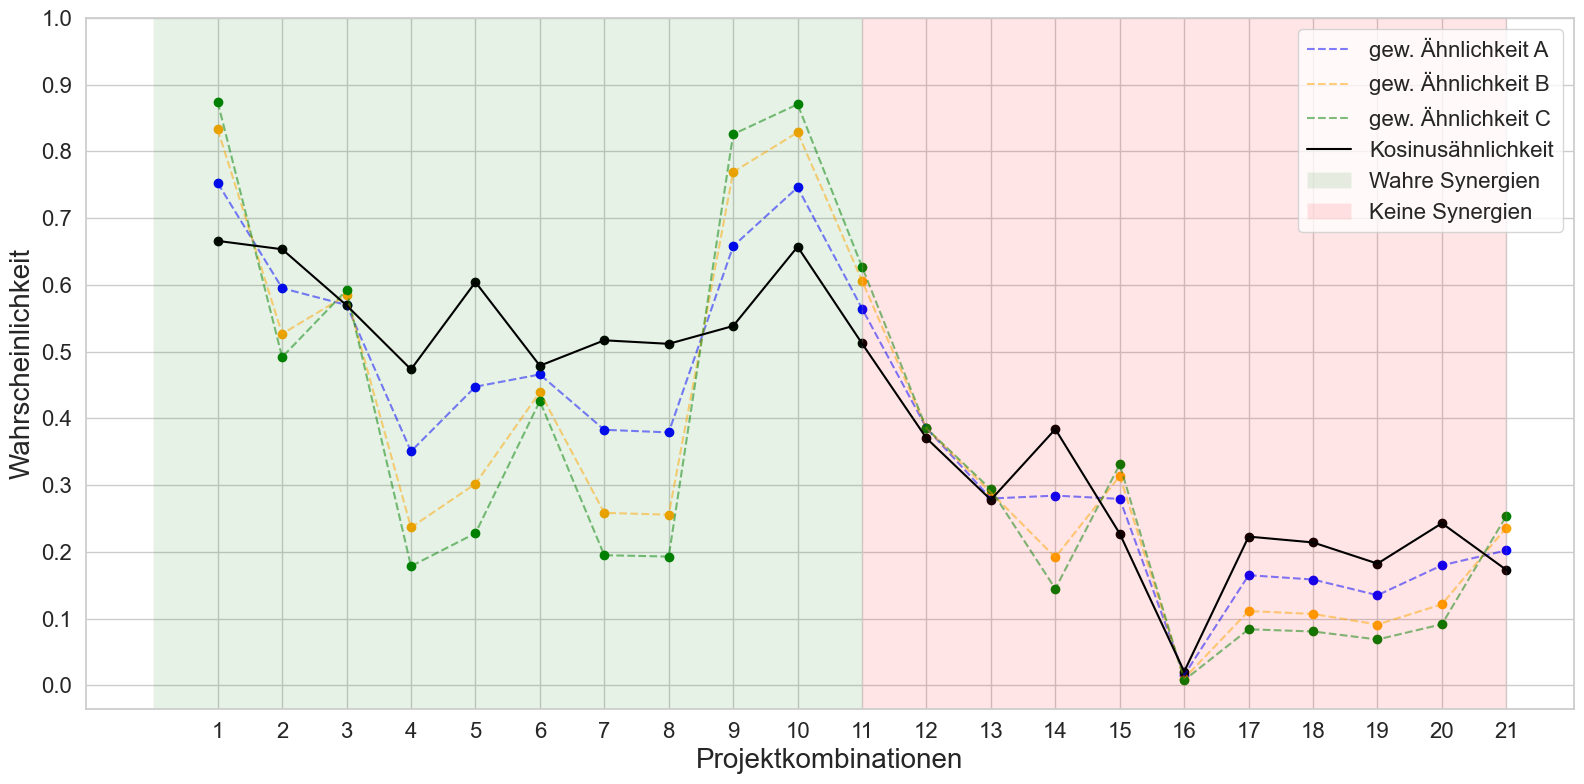

In [73]:
sns.set(style='whitegrid')

labels = [
    "gew. Ähnlichkeit A",
    "gew. Ähnlichkeit B",
    "gew. Ähnlichkeit C",
    "Kosinusähnlichkeit"
]

linestyles = ["--", "--", "--", "-"]
colors = ['blue', 'orange', 'green', 'black'] 
alphas = [0.5, 0.5, 0.5, 1]

plt.figure(figsize=(16, 8))
x_values = range(1, len(results_all_weighted[0]) + 1)

for i, results in enumerate(results_all_weighted):
    plt.plot(x_values, results, label=labels[i], linestyle=linestyles[i], alpha=alphas[i], color=colors[i])
    plt.scatter(x_values, results, color=colors[i])


#plt.title('Verschiedene Modelle zur Berechnung der Projektähnlichkeit')
plt.axvspan(0, len(true_matches), facecolor='green', alpha=0.1, label='Wahre Synergien')
plt.axvspan(len(true_matches), len(matches), facecolor='red', alpha=0.1, label='Keine Synergien')
plt.xlabel('Projektkombinationen', fontsize=20)
plt.ylabel('Wahrscheinlichkeit', fontsize=20)
plt.xticks(x_values, fontsize=16) 
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=16) 
plt.legend()
plt.tight_layout()
plt.legend(fontsize=16)

plt.savefig('../exploreation/img/eval_weighted.png')
plt.show()

## **Exponetially rising similarity Matrix**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


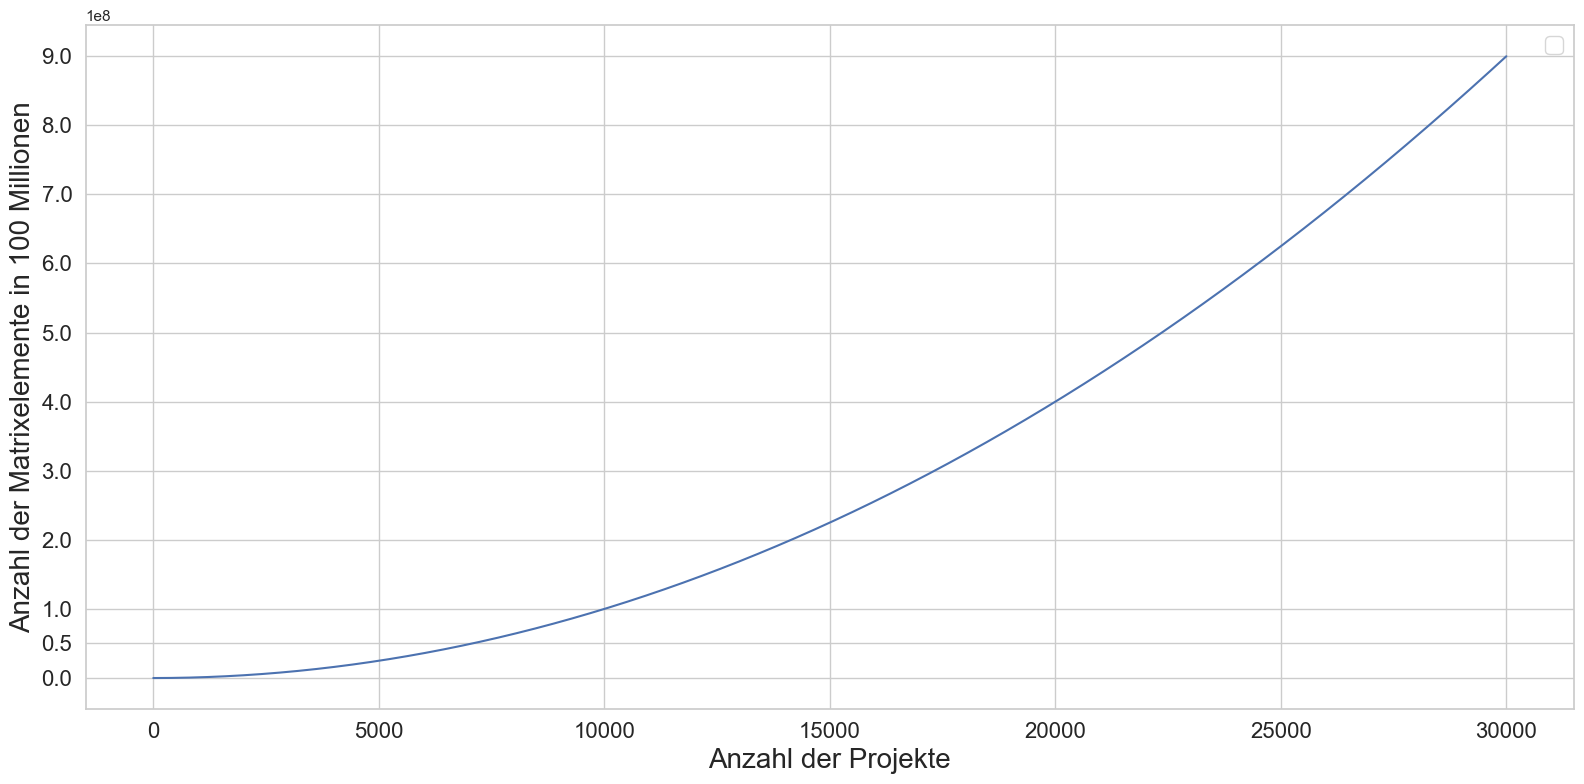

In [74]:
n_projects = np.arange(1, 30000)

matrix_elements = n_projects ** 2

plt.figure(figsize=(16, 8))
sns.lineplot(x=n_projects, y=matrix_elements)
#plt.title('Anzahl der Elemente in der Ähnlichkeitsmatrix für bis zu 50.000 Projekte')
plt.xlabel('Anzahl der Projekte', fontsize=20)
plt.ylabel('Anzahl der Matrixelemente in 100 Millionen', fontsize=20)
plt.yticks([0, 50000000, 100000000, 200000000, 300000000, 400000000, 500000000, 600000000, 700000000, 800000000, 900000000], fontsize=16)
#plt.yscale('log') 
plt.xticks(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig('../exploreation/img/expon_matrix.png')

plt.show()